### Installation

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#      install.packages("BiocManager")
#   BiocManager::install("cicero")

Vignette: https://www.bioconductor.org/packages/devel/bioc/vignettes/cicero/inst/doc/website.html

### Import packages

In [2]:
library(cicero)
library(data.table)
library(Matrix)
library(proxy)
library(reshape2)
library(BuenColors)
library(umap)

Loading required package: monocle
Loading required package: Matrix
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank,

### Preprocess

`bsub < count_reads_peaks.sh`

In [3]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 2034

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [5]:
dim(datafr)

[1] 237450   2034

In [6]:
df_regions = read.csv("../../input/combined.sorted.merged.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [7]:
dim(df_regions)

[1] 237450      3

In [8]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [9]:
head(peaknames)

[1] "chr1_10413_10625"   "chr1_13380_13624"   "chr1_16145_16354"  
[4] "chr1_96388_96812"   "chr1_115650_115812" "chr1_237625_237888"

In [10]:
head(sapply(strsplit(files,'\\.'),'[', 1))

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [11]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 1)
rownames(datafr) = peaknames

In [12]:
datafr[1:5,1:5]

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27
chr1_10413_10625,0,0,0,0,0
chr1_13380_13624,0,0,0,0,0
chr1_16145_16354,0,0,0,0,0
chr1_96388_96812,0,0,0,0,0
chr1_115650_115812,0,0,0,0,0


In [13]:
dim(datafr)

[1] 237450   2034

In [14]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [15]:
mat_sparse = as(datafr, "dgTMatrix")
cicero_data = data.frame(cbind(Peak=rownames(datafr)[mat_sparse@i+1],
                               Cell=colnames(datafr)[mat_sparse@j+1],
                               Count=mat_sparse@x),stringsAsFactors = FALSE)
cicero_data$Count = as.numeric(cicero_data$Count)

In [16]:
head(cicero_data)

Peak,Cell,Count
chr1_1240748_1241351,BM1077-CLP-Frozen-160106-13,4
chr1_2427677_2428017,BM1077-CLP-Frozen-160106-13,2
chr1_2486986_2488268,BM1077-CLP-Frozen-160106-13,2
chr1_8442693_8443580,BM1077-CLP-Frozen-160106-13,2
chr1_8877572_8878334,BM1077-CLP-Frozen-160106-13,2
chr1_9294304_9295359,BM1077-CLP-Frozen-160106-13,2


### Obtain Feature Matrix

In [17]:
start_time <- Sys.time()

In [18]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [19]:
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)

In [22]:
pData(input_cds)$label = metadata[rownames(pData(input_cds)),'label']

In [23]:
dim(input_cds)

Features  Samples 
  237450     2034

In [24]:
#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

In [25]:
dim(input_cds)

Features  Samples 
  237450     2034

In [26]:
#aggregate_nearby_peaks
agg_cds <- aggregate_nearby_peaks(input_cds, distance = 10000)
agg_cds <- detectGenes(agg_cds)
agg_cds <- estimateSizeFactors(agg_cds)
agg_cds <- estimateDispersions(agg_cds)

Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message:
"step size truncated due to divergence"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message:
"step size truncated due to divergence"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message:
"step size truncated due to divergence"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message:
"step size truncated due to divergence"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning message in log(ifelse(y == 0, 1, y/mu)):
"NaNs produced"Warning 

In [28]:
dim(agg_cds)

Features  Samples 
   77819     2034

In [67]:
normalize_expr_data <- function(cds,
                                norm_method = c("log", "vstExprs", "none"),
                                pseudo_expr = 1,
                                relative_expr = TRUE){
  FM <- exprs(cds)
  use_for_ordering <- NULL
  # If the user has selected a subset of genes for use in ordering the cells
  # via setOrderingFilter(), subset the expression matrix.
  if (is.null(fData(cds)$use_for_ordering) == FALSE &&
      nrow(subset(fData(cds), use_for_ordering == TRUE)) > 0) {
    FM <- FM[fData(cds)$use_for_ordering, ]
  }

  norm_method <- match.arg(norm_method)
  if (cds@expressionFamily@vfamily %in% c("negbinomial", "negbinomial.size")) {

    # If we're going to be using log, and the user hasn't given us a pseudocount
    # set it to 1 by default.
    if (is.null(pseudo_expr)){
      if(norm_method == "log")
        pseudo_expr = 1
      else
        pseudo_expr = 0
    }

    checkSizeFactors(cds)

    if (norm_method == "vstExprs") {
      if (relative_expr == FALSE)
        message("Warning: relative_expr is ignored when using norm_method == 'vstExprs'")

      if (is.null(fData(cds)$use_for_ordering) == FALSE &&
          nrow(subset(fData(cds), use_for_ordering == TRUE)) > 0) {
        VST_FM <- vstExprs(cds[fData(cds)$use_for_ordering,], round_vals = FALSE)
      }else{
        VST_FM <- vstExprs(cds, round_vals = FALSE)
      }

      if (is.null(VST_FM) == FALSE) {
        FM <- VST_FM
      }
      else {
        stop("Error: set the variance-stabilized value matrix with vstExprs(cds) <- computeVarianceStabilizedValues() before calling this function with use_vst=TRUE")
      }
    }else if (norm_method == "log") {
      # If we are using log, normalize by size factor before log-transforming
      
      if (relative_expr)
        FM <- Matrix::t(Matrix::t(FM)/sizeFactors(cds))

      if(is.null(pseudo_expr))
        pseudo_expr <- 1 
      FM <- FM + pseudo_expr
      FM <- log2(FM)
    }else if (norm_method == "none"){
      # If we are using log, normalize by size factor before log-transforming
      FM <- Matrix::t(Matrix::t(FM)/sizeFactors(cds))
      FM <- FM + pseudo_expr
    }
  }else if (cds@expressionFamily@vfamily == "binomialff") {
    if (norm_method == "none"){
      #If this is binomial data, transform expression values into TF-IDF scores.
      ncounts <- FM > 0
      ncounts[ncounts != 0] <- 1
      FM <- Matrix::t(Matrix::t(ncounts) * log(1 + ncol(ncounts)/rowSums(ncounts)))
    }else{
      stop("Error: the only normalization method supported with binomial data is 'none'")
    }
  }else if (cds@expressionFamily@vfamily == "Tobit") {
    FM <- FM + pseudo_expr
    if (norm_method == "none"){

    }else if (norm_method == "log"){
      FM <- log2(FM)
    }else{
      stop("Error: the only normalization methods supported with Tobit-distributed (e.g. FPKM/TPM) data are 'log' (recommended) or 'none'")
    }
  }else if (cds@expressionFamily@vfamily == "uninormal") {
    if (norm_method == "none"){
      FM <- FM + pseudo_expr
    }else{
      stop("Error: the only normalization method supported with gaussian data is 'none'")
    }
  }
  # if(norm_method != "none")
    #normalize_expr_data
  return (FM)
}

checkSizeFactors <- function(cds)
{
  if (cds@expressionFamily@vfamily %in% c("negbinomial", "negbinomial.size"))
  {
    if (is.null(sizeFactors(cds))){
      stop("Error: you must call estimateSizeFactors() before calling this function.")
    }
    if (sum(is.na(sizeFactors(cds))) > 0){
      stop("Error: one or more cells has a size factor of NA.")
    }
  }
}

In [77]:
max_components=3
norm_method = 'log'
residualModelFormulaStr=NULL
use_existing_pc_variance=FALSE
pseudo_expr=NULL
return_all = F
verbose=FALSE

In [69]:
cds = agg_cds 

In [70]:
set.seed(2016)
FM <- normalize_expr_data(cds, norm_method, pseudo_expr)

#FM <- FM[unlist(sparseApply(FM, 1, sd, convert_to_dense=TRUE)) > 0, ]
xm <- Matrix::rowMeans(FM)
xsd <- sqrt(Matrix::rowMeans((FM - xm)^2))
FM <- FM[xsd > 0,]

In [72]:
if (is.null(residualModelFormulaStr) == FALSE) {
  if (verbose) 
    message("Removing batch effects")
  X.model_mat <- sparse.model.matrix(as.formula(residualModelFormulaStr), 
                                     data = pData(cds), drop.unused.levels = TRUE)

  fit <- limma::lmFit(FM, X.model_mat, ...)
  beta <- fit$coefficients[, -1, drop = FALSE]
  beta[is.na(beta)] <- 0
  FM <- as.matrix(FM) - beta %*% t(X.model_mat[, -1])
}else{
  X.model_mat <- NULL
}


In [73]:
    if (nrow(FM) == 0) {
      stop("Error: all rows have standard deviation zero")
    }



In [75]:
dim(t(FM))

[1]  2034 77819

In [87]:
dim(FM)

[1] 77819  2034

In [81]:
tmp = t(FM)

In [83]:
tmp[100:103,1000:1005]

4 x 6 Matrix of class "dgeMatrix"
                            chr1_153643305_153682970 chr1_15364631_15373343
BM1077-CMP-Frozen-160106-91                0.8854059              0.8854059
BM1077-CMP-Frozen-160106-92                0.0000000              0.0000000
BM1077-CMP-Frozen-160106-95                0.9061892              0.0000000
BM1077-GMP-Frozen-160107-1                 0.0000000              0.0000000
                            chr1_153699956_153778381 chr1_153789062_153827086
BM1077-CMP-Frozen-160106-91                 0.000000                        0
BM1077-CMP-Frozen-160106-92                 1.684496                        0
BM1077-CMP-Frozen-160106-95                 1.458475                        0
BM1077-GMP-Frozen-160107-1                  0.000000                        0
                            chr1_153837733_153861588 chr1_15386380_15389155
BM1077-CMP-Frozen-160106-91                        0                      0
BM1077-CMP-Frozen-160106-92                 

In [84]:
?prcomp_irlba

In [85]:
?irlba

In [112]:
tmp2 <- irlba(FM[2000:4000,1:1000], 100, 100,scale=TRUE,center=TRUE)

In [100]:
irlba_res <- prcomp_irlba(FM[2000:4000,1:1000], n = min(max_components, min(dim(FM)) - 1),
                          center = TRUE, scale. = TRUE)

In [113]:
tmp2$d

[1] 189.89925  35.77703  32.67526  31.30766  30.27696  30.00736  29.25584
  [8]  28.87422  28.20256  28.04271  28.01727  27.25450  27.12608  26.83770
 [15]  26.45531  26.42535  26.04212  25.92113  25.58073  25.42615  25.19359
 [22]  25.12474  24.86784  24.68547  24.47510  24.33219  24.11877  23.75276
 [29]  23.71191  23.58362  23.56446  23.36778  23.15625  23.11193  23.01556
 [36]  23.00201  22.79480  22.68976  22.59028  22.52527  22.21936  22.08991
 [43]  22.01806  21.94544  21.81282  21.71038  21.48497  21.35556  21.26285
 [50]  21.24645  21.14981  21.03368  20.98224  20.83148  20.76579  20.75046
 [57]  20.68517  20.62043  20.49405  20.44547  20.40570  20.27600  20.13420
 [64]  20.05984  19.99183  19.89818  19.79826  19.69287  19.64806  19.56355
 [71]  19.45415  19.43196  19.34383  19.18476  19.13152  19.03923  18.98200
 [78]  18.90118  18.89790  18.80976  18.64620  18.58024  18.53110  18.41088
 [85]  18.34495  18.26433  18.19010  18.12642  18.07967  18.03509  17.92484
 [92]  17.89016  17.86175  17.80592  17.76029  17.73111  17.67673  17.62899
 [99]  17.52206  17.45440

In [114]:
df_plot = data.frame(PC=1:100, SD=tmp2$d);
#     print(SVD$d[1:num_pcs])
p <- ggplot(df_plot, aes(x = PC, y = SD)) +
  geom_point(col="#cd5c5c",size = 1) 

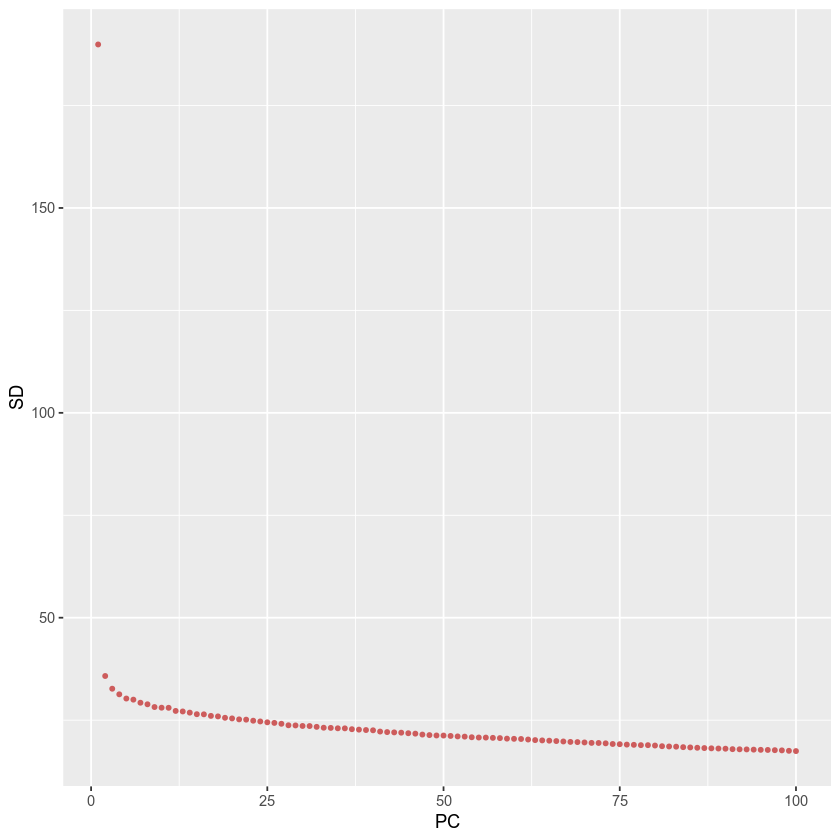

In [115]:
p

In [108]:
tmp2

-0.010470225,-0.0022148641,-1.121091e-03
-0.007357179,-0.0059867213,9.502638e-04
-0.007284507,-0.0057336428,9.452472e-04
-0.009741038,-0.0006543541,1.316262e-05
-0.003088059,0.0081666830,-1.421412e-02
-0.009265579,0.0011446134,-3.432598e-03
-0.009869124,0.0016117564,-2.742488e-03
-0.004314577,0.0072147041,-4.595740e-03
-0.006551798,0.0032160047,3.994312e-03
-0.010600336,-0.0025638260,-9.522944e-04
-0.010600336,-0.0025638260,-9.522944e-04


In [101]:
irlba_res

Standard deviations (1, .., p=3):
[1] 16.795371  3.061077  2.789541

Rotation (n x k) = (1000 x 3):
                PC1           PC2           PC3
   [1,] 0.022270504  1.585025e-02  5.798393e-02
   [2,] 0.019813657 -6.393758e-02 -1.040182e-02
   [3,] 0.019152175  1.511469e-02  7.674221e-02
   [4,] 0.019228801  9.168773e-03  2.931116e-02
   [5,] 0.015078345 -1.949566e-02  1.189488e-02
   [6,] 0.030595924 -2.065981e-02  3.018578e-02
   [7,] 0.022310812  8.851475e-03  8.303272e-02
   [8,] 0.022250579  3.571579e-02  4.343067e-02
   [9,] 0.028640394 -4.992285e-02  3.096204e-02
  [10,] 0.027992250 -9.530498e-02  4.069067e-02
  [11,] 0.020249922  2.635377e-02  6.124796e-02
  [12,] 0.028045649  2.435972e-02  6.154448e-03
  [13,] 0.018991924 -4.022894e-02 -1.676345e-02
  [14,] 0.027127171  2.975785e-02  6.815859e-03
  [15,] 0.023540266  3.781975e-02  3.511136e-02
  [16,] 0.020831084 -4.134670e-02 -1.564709e-02
  [17,] 0.025851554  6.586476e-02  4.918544e-02
  [18,] 0.020282704  1.412802e-02  4

In [50]:
plot_pc_variance_explained <- function(cds, 
                            max_components=100, 
                            # reduction_method=c("DDRTree", "ICA", 'tSNE'),
                            norm_method = c("log", "vstExprs", "none"), 
                            residualModelFormulaStr=NULL,
                            pseudo_expr=NULL, 
                            return_all = F, 
                            use_existing_pc_variance=FALSE,
                            verbose=FALSE, 
                            ...){
  set.seed(2016)
  if(!is.null(cds@auxClusteringData[["tSNE"]]$variance_explained) & use_existing_pc_variance == T){
    prop_varex <- cds@auxClusteringData[["tSNE"]]$variance_explained
  }
  else{
    FM <- normalize_expr_data(cds, norm_method, pseudo_expr)
    
    #FM <- FM[unlist(sparseApply(FM, 1, sd, convert_to_dense=TRUE)) > 0, ]
    xm <- Matrix::rowMeans(FM)
    xsd <- sqrt(Matrix::rowMeans((FM - xm)^2))
    FM <- FM[xsd > 0,]
    
    if (is.null(residualModelFormulaStr) == FALSE) {
      if (verbose) 
        message("Removing batch effects")
      X.model_mat <- sparse.model.matrix(as.formula(residualModelFormulaStr), 
                                         data = pData(cds), drop.unused.levels = TRUE)
      
      fit <- limma::lmFit(FM, X.model_mat, ...)
      beta <- fit$coefficients[, -1, drop = FALSE]
      beta[is.na(beta)] <- 0
      FM <- as.matrix(FM) - beta %*% t(X.model_mat[, -1])
    }else{
      X.model_mat <- NULL
    }
    
    if (nrow(FM) == 0) {
      stop("Error: all rows have standard deviation zero")
    }
    
    # FM <- convert2DRData(cds, norm_method = 'log') 
    # FM <- FM[rowSums(is.na(FM)) == 0, ]
    irlba_res <- prcomp_irlba(t(FM), n = min(max_components, min(dim(FM)) - 1),
                              center = TRUE, scale. = TRUE)
    prop_varex <- irlba_res$sdev^2 / sum(irlba_res$sdev^2)
    # 
    # cell_means <- Matrix::rowMeans(FM_t)
    # cell_vars <- Matrix::rowMeans((FM_t - cell_means)^2)
    # 
    # irlba_res <- irlba(FM,
    #                    nv= min(max_components, min(dim(FM)) - 1), #avoid calculating components in the tail
    #                    nu=0,
    #                    center=cell_means,
    #                    scale=sqrt(cell_vars),
    #                    right_only=TRUE)
    # prop_varex <- irlba_res$d / sum(irlba_res$d)
    # 
    # # pca_res <- prcomp(t(FM), center = T, scale = T)
    # # std_dev <- pca_res$sdev 
    # # pr_var <- std_dev^2
    # prop_varex <- pr_var/sum(pr_var)
  }
  
  p <- qplot(1:length(prop_varex), prop_varex, alpha = I(0.5)) +  monocle_theme_opts() + 
    theme(legend.position="top", legend.key.height=grid::unit(0.35, "in")) +
    theme(panel.background = element_rect(fill='white')) + xlab('components') + 
    ylab('Variance explained \n by each component')
  
  cds@auxClusteringData[["tSNE"]]$variance_explained <- prop_varex # update CDS slot for variance_explained 

  if(return_all) {
    return(list(variance_explained = prop_varex, p = p))
  }
  else
    return(p)  
}

In [34]:
#Choose sites by dpFeature
plot_pc_variance_explained(agg_cds, return_all = FALSE) #Choose 2 PCs

In [49]:
plot_pc_variance_explained(agg_cds)

In [46]:
agg_cds <- reduceDimension(agg_cds,
                              max_components = 2,
                              norm_method = 'log',
                              num_dim = 15,
                              reduction_method = 'tSNE',
                              verbose = TRUE)

Remove noise by PCA ...
Reduce dimension by tSNE ...


In [47]:
agg_cds <- clusterCells(agg_cds, verbose = FALSE)

Distance cutoff calculated to 2.377171 


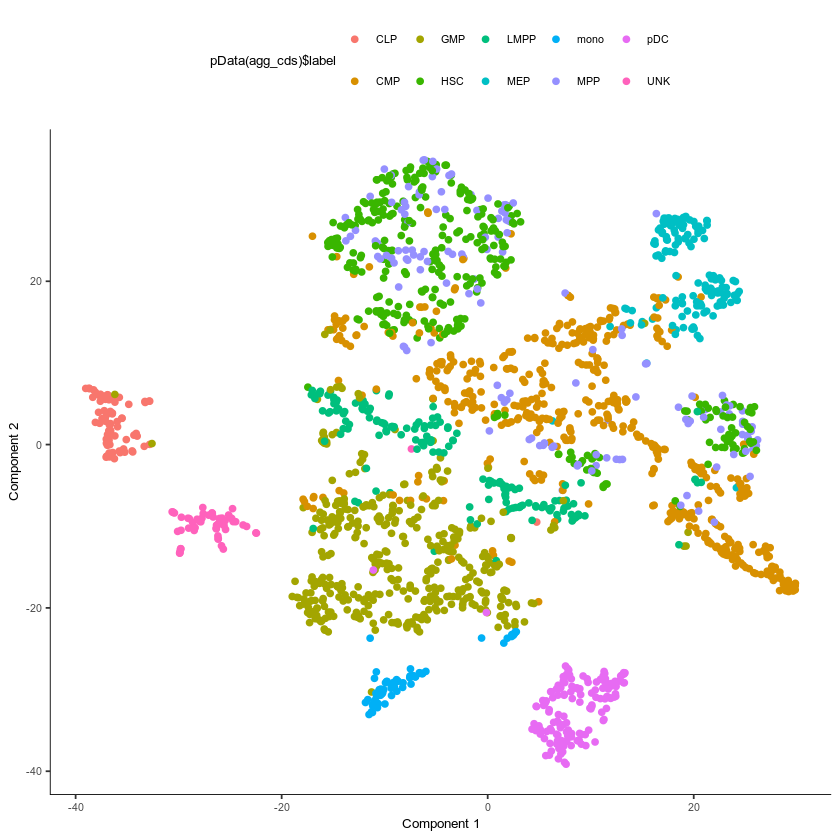

In [48]:
plot_cell_clusters(agg_cds, color_by = 'pData(agg_cds)$label') + theme(text = element_text(size=8))

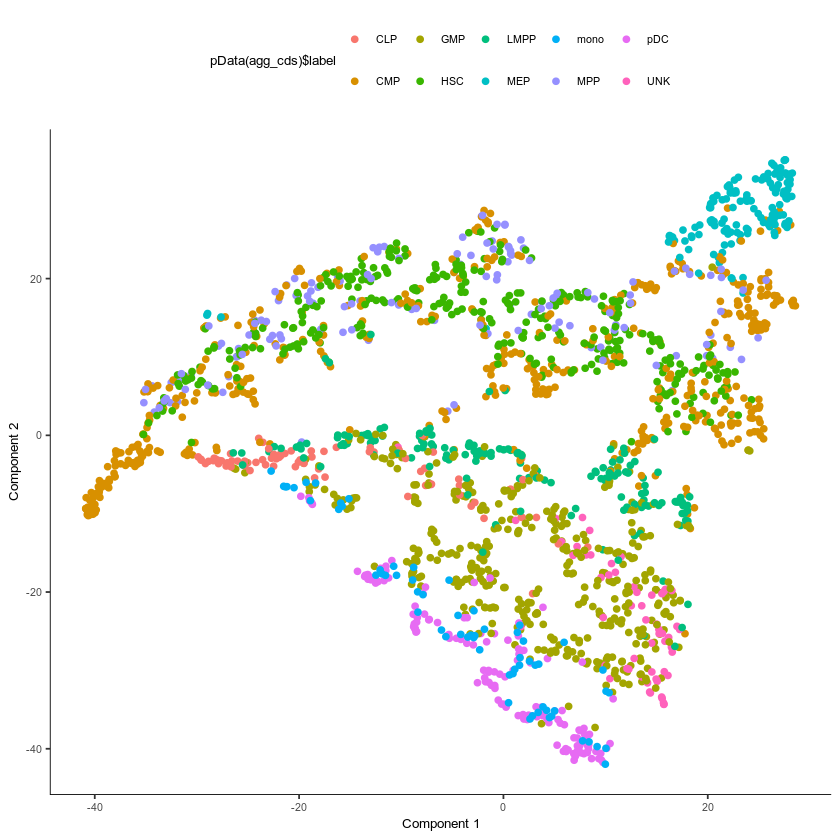

In [45]:
plot_cell_clusters(agg_cds, color_by = 'pData(agg_cds)$label') + theme(text = element_text(size=8))

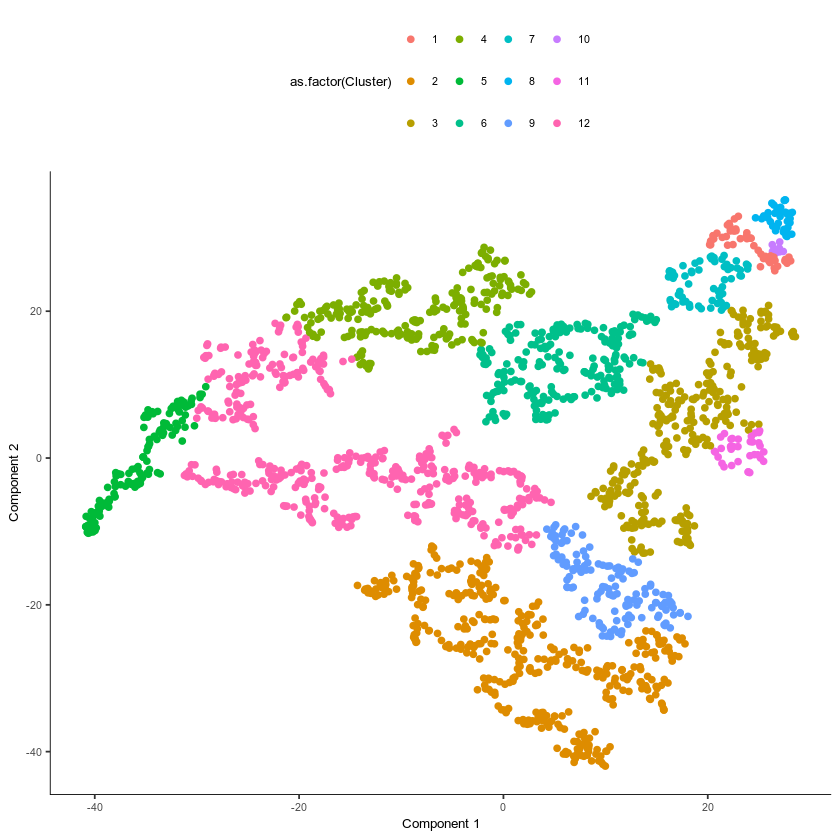

In [37]:
plot_cell_clusters(agg_cds, color_by = 'as.factor(Cluster)') + theme(text = element_text(size=8))

In [39]:
clustering_DA_sites <- differentialGeneTest(agg_cds, #Subset for example only
                                             fullModelFormulaStr = '~Cluster')

In [24]:
set.seed(2019)
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)
input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=15,
                        reduction_method = 'tSNE', norm_method = "none")

In [25]:
tsne_coords <- t(reducedDimA(input_cds))

In [26]:
head(tsne_coords)

5.978882,-24.45483
6.585963,-28.13208
6.676215,-28.01971
6.429126,-28.21335
4.781831,-25.64204
4.746844,-21.90432


In [27]:
df_tsne_coords = data.frame(cbind(tsne_coords,as.character(pData(input_cds)$label)),stringsAsFactors = FALSE)
colnames(df_tsne_coords) = c('tsne_1','tsne_2','label')
df_tsne_coords$tsne_1 = as.numeric(df_tsne_coords$tsne_1)
df_tsne_coords$tsne_2 = as.numeric(df_tsne_coords$tsne_2)

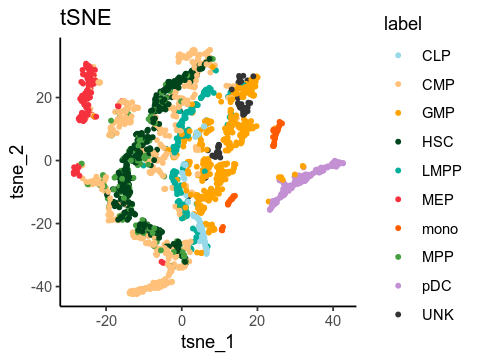

In [28]:
all_color_maps <- c(jdb_color_maps, "UNK" = "#333333" )
options(repr.plot.width=4, repr.plot.height=3)
p <- ggplot(shuf(df_tsne_coords), aes(x = tsne_1, y = tsne_2, color = label)) +
  geom_point(size = 1) + scale_color_manual(values = all_color_maps) +
  ggtitle('tSNE') + theme_classic()
p

In [29]:
data("human.hg19.genome")
genome_ref = human.hg19.genome
file_tss='../../input/hg19/hg19-tss.bed'

In [30]:
head(genome_ref)

V1,V2
chr1,249250621
chr2,243199373
chr3,198022430
chr4,191154276
chr5,180915260
chr6,171115067


In [31]:
row.names(tsne_coords) <- row.names(pData(input_cds))
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords)
conns <- run_cicero(cicero_cds, genome_ref) # Takes a few minutes to run

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 1.43827978041384
Median shared cells bin-bin: 0


[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Done"


In [32]:
gene_annotation <- read.table(file_tss,sep='\t')
names(gene_annotation)[4] <- "gene"    
gene_annotation_pos <- subset(gene_annotation, V5 == "+")
gene_annotation_pos$V3 <- gene_annotation_pos$V2 + 1
gene_annotation_neg <- subset(gene_annotation, V5 == "-")
gene_annotation_neg$V2 <- gene_annotation_neg$V3 - 1
tss <- rbind(gene_annotation_pos, gene_annotation_neg)    

In [33]:
input_cds <- annotate_cds_by_site(input_cds, tss)
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, conns)
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0,]

# make a list of num_genes_expressed
num_genes <- pData(input_cds)$num_genes_expressed
names(num_genes) <- row.names(pData(input_cds))

# normalize
cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)    
fm_Cicero = as.matrix(cicero_gene_activities)

In [34]:
end_time <- Sys.time()

In [35]:
end_time - start_time

Time difference of 15.9385 mins

In [36]:
all(colnames(fm_Cicero) == rownames(metadata))

[1] TRUE

In [37]:
saveRDS(fm_Cicero, file = '../../output/feature_matrices/FM_Cicero_buenrostro2018.rds')

### Downstream Analysis

In [38]:
df_umap_Cicero <- umap(t(fm_Cicero))$layout

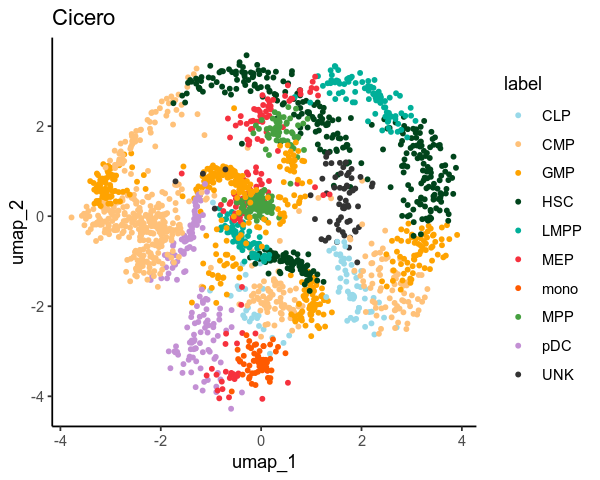

In [39]:
df_umap = data.frame(cbind(df_umap_Cicero,metadata[rownames(pData(input_cds)),'label']),stringsAsFactors = FALSE)
colnames(df_umap) = c('umap_1','umap_2','label')
df_umap$umap_1 = as.numeric(df_umap$umap_1)
df_umap$umap_2 = as.numeric(df_umap$umap_2)
options(repr.plot.width=5, repr.plot.height=4)
p <- ggplot(df_umap, aes(x = umap_1, y = umap_2, color = label)) +
  geom_point(size = 1) + scale_color_manual(values = all_color_maps) +
  ggtitle('Cicero') + theme_classic()
p

In [40]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_Cicero/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      splines   stats4    parallel  stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] umap_0.2.2.0         BuenColors_0.5.5     MASS_7.3-51.1       
 [4] reshape2_1.4.3       proxy_0.4-23         data.table_1.12.0   
 [7] cicero_1.0.15        Gviz_1.26.5          GenomicRanges_1.34.0
[10] GenomeInfoDb_1.18.1  IR

In [41]:
save.image(file = 'Cicero_buenrostro2018_genescores.RData')